# BA820 Milestone 2 Pet Cats UK (Bruce Liu)

**Domain Question**  
Do UK pet cats show distinct behavioral roaming patterns in how they use space over time that are not adequately captured by simple movement summaries or explained by basic cat-level attributes?

This notebook focuses on:
- Revisiting key EDA findings from M1 that motivate a more behavior-focused analysis
- Refining preprocessing to make cats more comparable on movement behavior (not just tracking density)
- Constructing movement-derived features as a foundation for unsupervised behavioral pattern discovery


## EDA & Preprocessing Updates

This section revisits key findings from M1 and documents new or refined preprocessing steps that support behavioral pattern discovery.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cats_gps = pd.read_csv(r'C:\Users\liubr\OneDrive\Documents\GitHub\BA820-TeamB7\cats_uk.csv')
cats_ref = pd.read_csv(r'C:\Users\liubr\OneDrive\Documents\GitHub\BA820-TeamB7\cats_uk_reference.csv')

cats_gps.head(2)


,tag_id,event_id,visible,timestamp,location_long,location_lat,ground_speed,height_above_ellipsoid,algorithm_marked_outlier,manually_marked_outlier,study_name
0,Ares,3395610551,True,2017-06-24T01:03:57Z,-5.113851,50.170315,684,154.67,False,False,Pet Cats United Kingdom
1,Ares,3395610552,True,2017-06-24T01:11:20Z,-5.113851,50.170315,936,154.67,False,False,Pet Cats United Kingdom


In [63]:
cats_ref.head(2)

,tag_id,animal_id,animal_taxon,deploy_on_date,deploy_off_date,hunt,prey_p_month,animal_reproductive_condition,animal_sex,hrs_indoors,n_cats,food_dry,food_wet,food_other,study_site,age_years
0,Tommy-Tag,Tommy,Felis catus,2017-06-03T01:02:09Z,2017-06-10T02:10:52Z,True,12.5,Neutered,m,12.5,2,True,True,False,UK,11.0
1,Athena,Athena,Felis catus,2017-06-24T01:02:13Z,2017-06-30T23:59:32Z,True,3.0,Spayed,f,7.5,2,True,True,False,UK,3.0


In [64]:
cats_gps.info()
print()
cats_ref.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18215 entries, 0 to 18214
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tag_id                    18215 non-null  object 
 1   event_id                  18215 non-null  int64  
 2   visible                   18215 non-null  bool   
 3   timestamp                 18215 non-null  object 
 4   location_long             18215 non-null  float64
 5   location_lat              18215 non-null  float64
 6   ground_speed              18215 non-null  int64  
 7   height_above_ellipsoid    18215 non-null  float64
 8   algorithm_marked_outlier  18215 non-null  bool   
 9   manually_marked_outlier   18215 non-null  bool   
 10  study_name                18215 non-null  object 
dtypes: bool(3), float64(3), int64(2), object(3)
memory usage: 1.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 16 columns):

### Preprocessing

In [65]:
# number of GPS points per cat (tag_id)
points_per_cat = (
    cats_gps
    .groupby("tag_id")["event_id"]
    .count()
    .rename("n_points")
    .reset_index()
)

points_per_cat.describe()


,n_points
count,101.000000
mean,180.346535
std,146.280582
min,12.000000
25%,100.000000
50%,155.000000
75%,214.000000
max,963.000000


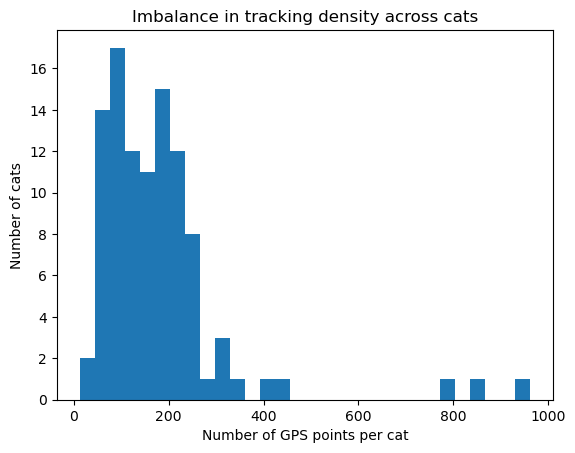

In [66]:
plt.figure()
plt.hist(points_per_cat["n_points"], bins=30)
plt.xlabel("Number of GPS points per cat")
plt.ylabel("Number of cats")
plt.title("Imbalance in tracking density across cats")
plt.show()


Join GPS with reference data, later will merge cat level features with this

In [67]:
# Ensure tag_id is same type in both
cats_ref["tag_id"] = cats_ref["tag_id"].astype(str)
cats_gps["tag_id"] = cats_gps["tag_id"].astype(str)

# basic join key check
sorted(cats_gps["tag_id"].unique())[:5], sorted(cats_ref["tag_id"].unique())[:5]

(['Abba-Tag', 'Alfie-Tag', 'Amber-Tag', 'Ares', 'Athena'],
 ['Abba-Tag', 'Alfie-Tag', 'Amber-Tag', 'Ares', 'Athena'])

Filter cats with sufficient data for behavioral analysis. Chose 80 points for more normal distribution of sampling data

In [68]:
MIN_POINTS = 80

eligible_cats = points_per_cat.loc[points_per_cat["n_points"] >= MIN_POINTS, "tag_id"]

print(f"Total cats: {points_per_cat.shape[0]}")
print(f"Cats with >= {MIN_POINTS} GPS points: {eligible_cats.shape[0]}")

cats_gps_filtered = cats_gps[cats_gps["tag_id"].isin(eligible_cats)].copy()


Total cats: 101
Cats with >= 80 GPS points: 84


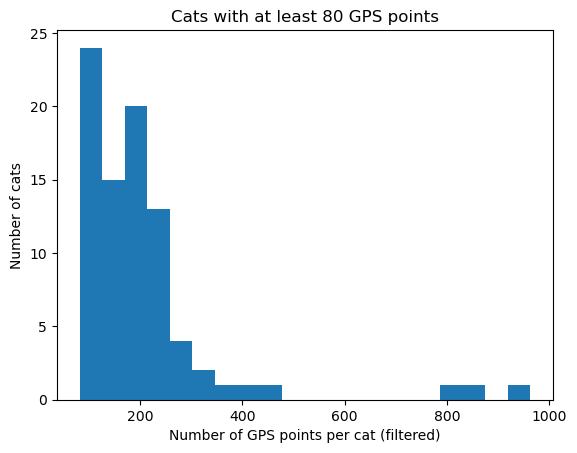

In [69]:
plt.figure()
plt.hist(points_per_cat.loc[points_per_cat["n_points"] >= MIN_POINTS, "n_points"], bins=20)
plt.xlabel("Number of GPS points per cat (filtered)")
plt.ylabel("Number of cats")
plt.title(f"Cats with at least {MIN_POINTS} GPS points")
plt.show()


3 outlier cats with many more gps points (Over 800)

### Feature Engineering

Building distance function, used Haversine which is Euclidean but accounts for Earth's curvature

In [70]:
# simple haversine distance in meters
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Approximate great-circle distance between two points (in degrees).
    Returns distance in meters.
    """
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c


prepare and sort gps data

In [71]:
# ensure timestamps are in datetime
cats_gps_filtered["timestamp"] = pd.to_datetime(cats_gps_filtered["timestamp"])

cats_gps_filtered = cats_gps_filtered.sort_values(["tag_id", "timestamp"]).reset_index(drop=True)


distances per cat

In [72]:
# shift lat/lon within each cat to get previous point
cats_gps_filtered["prev_lat"] = cats_gps_filtered.groupby("tag_id")["location_lat"].shift(1)
cats_gps_filtered["prev_lon"] = cats_gps_filtered.groupby("tag_id")["location_long"].shift(1)

# distance between successive points (meters)
mask_valid = cats_gps_filtered["prev_lat"].notna()

cats_gps_filtered.loc[mask_valid, "step_distance_m"] = haversine_distance(
    cats_gps_filtered.loc[mask_valid, "prev_lat"],
    cats_gps_filtered.loc[mask_valid, "prev_lon"],
    cats_gps_filtered.loc[mask_valid, "location_lat"],
    cats_gps_filtered.loc[mask_valid, "location_long"],
)


### Constructing cat-level behavior features:
- mean step distance
- median step distance
- variability of step distance
- total distance traveled
- "radius of gyration" as dispersion proxy

In [73]:
def radius_of_gyration(latitudes, longitudes):
    """
    Rough radius of gyration in meters: distance of each point from the mean position.
    """
    if len(latitudes) == 0:
        return np.nan
    lat_mean = np.mean(latitudes)
    lon_mean = np.mean(longitudes)
    dists = haversine_distance(latitudes, longitudes, lat_mean, lon_mean)
    return np.sqrt(np.mean(dists**2))

cat_behavior_features = (
    cats_gps_filtered
    .groupby("tag_id")
    .apply(
        lambda group: pd.Series({
            "n_points": group.shape[0],
            "mean_step_m": group["step_distance_m"].mean(),
            "median_step_m": group["step_distance_m"].median(),
            "std_step_m": group["step_distance_m"].std(),
            "total_distance_m": group["step_distance_m"].sum(),
            "radius_of_gyration_m": radius_of_gyration(group["location_lat"].values,
                                                       group["location_long"].values),
        })
    )
    .reset_index()
)

cat_behavior_features.head()


C:\Users\liubr\AppData\Local\Temp\ipykernel_4328\1322589143.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,tag_id,n_points,mean_step_m,median_step_m,std_step_m,total_distance_m,radius_of_gyration_m
0,Abba-Tag,83.0,51.504820,32.155796,116.826826,4223.395217,92.812558
1,Alfie-Tag,187.0,58.813090,41.127444,75.232820,10939.234785,157.199058
2,Amber-Tag,218.0,85.784744,43.875990,400.028313,18615.289455,297.050218
3,Ares,103.0,40.599845,37.666476,28.945233,4141.184225,56.132732
4,Athena,106.0,31.946235,21.692483,42.858601,3354.354641,40.246819


### Normalize and scale features

In [74]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    "mean_step_m",
    "median_step_m",
    "std_step_m",
    "total_distance_m",
    "radius_of_gyration_m",
]

scaler = StandardScaler()
behavior_scaled = scaler.fit_transform(cat_behavior_features[feature_cols])

behavior_scaled_df = pd.DataFrame(
    behavior_scaled,
    columns=[f"{c}_scaled" for c in feature_cols],
)
behavior_scaled_df["tag_id"] = cat_behavior_features["tag_id"]

behavior_scaled_df.head()


,mean_step_m_scaled,median_step_m_scaled,std_step_m_scaled,total_distance_m_scaled,radius_of_gyration_m_scaled,tag_id
0,-0.195459,0.341893,-0.192074,-0.439904,-0.269812,Abba-Tag
1,-0.112147,1.274138,-0.243664,-0.144298,-0.159263,Alfie-Tag
2,0.195321,1.559740,0.159183,0.193573,0.080855,Amber-Tag
3,-0.319772,0.914508,-0.301075,-0.443522,-0.332789,Ares
4,-0.418420,-0.745351,-0.283818,-0.478155,-0.360065,Athena


In [75]:
cat_behavior_features[feature_cols].describe()


,mean_step_m,median_step_m,std_step_m,total_distance_m,radius_of_gyration_m
count,84.000000,84.000000,84.000000,84.000000,84.000000
mean,68.650840,28.865520,271.686755,14217.517143,249.958093
std,88.248809,9.681502,811.092709,22855.343385,585.924411
min,15.567277,7.951659,15.017879,1566.208558,20.509527
25%,35.311165,22.127731,37.531863,5373.841342,55.853479
50%,44.247401,27.401606,68.184552,8138.694776,89.141913
75%,62.692964,33.964356,127.454854,13809.899436,173.912989
max,597.061798,57.676377,6002.709422,147252.011539,4239.171947


## 3. Analysis & Experiments

This section applies unsupervised methods to explore whether distinct behavioral roaming patterns emerge from movement-derived features. The goal is not to force categorization, but to assess whether meaningful behavioral structure exists beyond simple movement summaries.


### 3.1 Behavioral Structure in Movement Features

This analysis explores whether cats exhibit hidden structure in roaming behavior when represented using movement-derived features. Rather than assuming that cats naturally fall into distinct behavioral types, this analysis asks whether any separation emerges organically from the data once tracking-density effects are reduced.

If meaningful structure exists, it would support the hypothesis that cats differ not only in how far they roam, but in how they use space over time. If structure is weak or overlapping, this would suggest that roaming behavior lies on a continuum rather than forming discrete categories.


In [76]:
feature_cols = [
    "mean_step_m",
    "median_step_m",
    "std_step_m",
    "total_distance_m",
    "radius_of_gyration_m",
]

cat_behavior_features[feature_cols].corr()


,mean_step_m,median_step_m,std_step_m,total_distance_m,radius_of_gyration_m
mean_step_m,1.000000,0.001664,0.963393,0.903160,0.969048
median_step_m,0.001664,1.000000,-0.091022,-0.058158,-0.035164
std_step_m,0.963393,-0.091022,1.000000,0.919161,0.990178
total_distance_m,0.903160,-0.058158,0.919161,1.000000,0.932894
radius_of_gyration_m,0.969048,-0.035164,0.990178,0.932894,1.000000


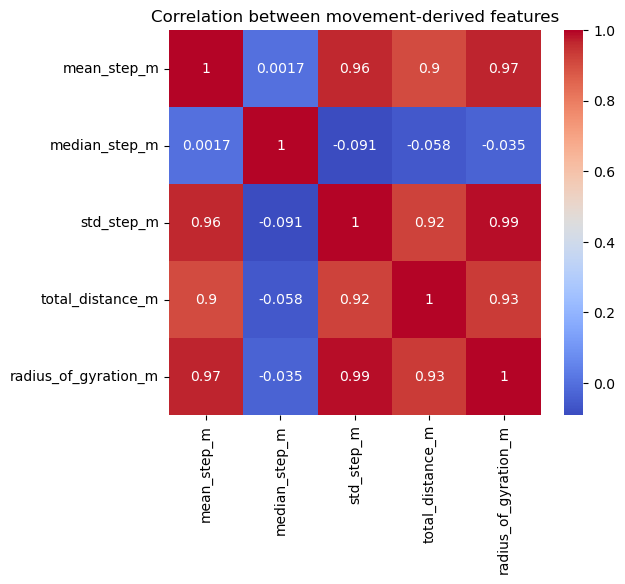

In [77]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cat_behavior_features[feature_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between movement-derived features")
plt.show()


**Feature inspection insight:**  
Most movement-derived features are highly correlated, indicating that they primarily capture a single underlying dimension related to overall movement scale or spatial dispersion. In contrast, median step distance shows little correlation with these features, suggesting it captures a distinct aspect of movement behavior related to typical step size rather than overall range.

This redundancy implies that naive clustering on all features may be dominated by scale effects, potentially obscuring more subtle behavioral differences.


# Dimensionality Reduction

In [78]:
from sklearn.decomposition import PCA

X = behavior_scaled_df[[f"{c}_scaled" for c in feature_cols]].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca.explained_variance_ratio_


array([0.76851716, 0.20036096])

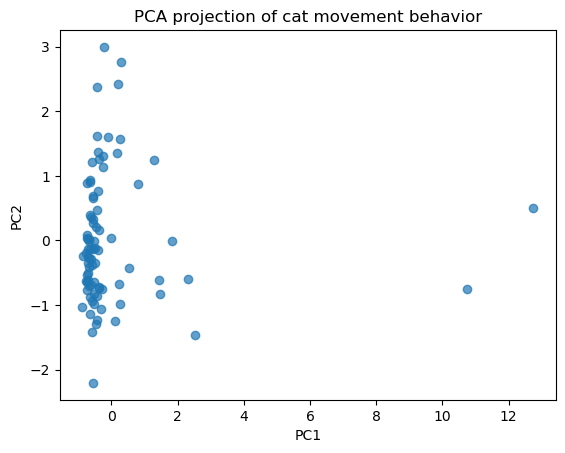

In [79]:
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of cat movement behavior")
plt.show()


**Initial observation:**  
The PCA projection does / does not reveal clearly separated groups. While some spread is visible along the first principal component, substantial overlap remains across cats, suggesting that roaming behavior may not separate cleanly into distinct clusters.


### K-means Clustering

c:\Users\liubr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\liubr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\liubr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\liubr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

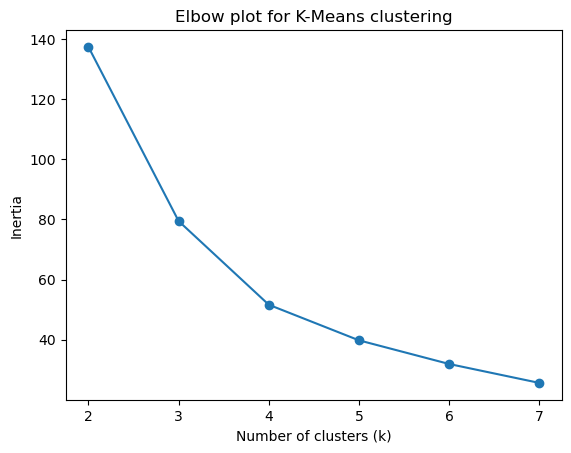

In [80]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow plot for K-Means clustering")
plt.show()


In [81]:
k = 4  # can adjust
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X)


c:\Users\liubr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


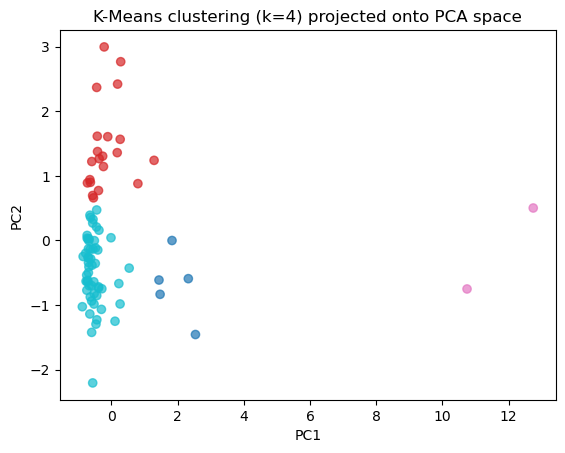

In [82]:
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_km, cmap="tab10", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means clustering (k={k}) projected onto PCA space")
plt.show()


**Clustering result interpretation:**  
Projecting K-means clusters onto PCA space reveals that cluster separation is dominated by a small number of extreme cats along the primary movement scale axis (PC1), while the majority of cats form a dense, overlapping cloud. Within this dense region, clusters are separated primarily along PC2 with no clear boundaries.

This suggests that K-means is partitioning a largely continuous distribution rather than uncovering distinct behavioral groups. Cluster assignments appear sensitive to outliers and do not correspond to well-separated roaming behavior types.


### Inverse PCA

In [83]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


In [84]:
X_scaled_reconstructed = pca.inverse_transform(X_pca)


In [85]:
X_reconstructed = scaler.inverse_transform(X_scaled_reconstructed)


In [86]:
def inverse_pca_transform(X_pca, pca, scaler):
    """
    Reconstruct original feature space from PCA coordinates.
    """
    X_scaled_recon = pca.inverse_transform(X_pca)
    X_original_recon = scaler.inverse_transform(X_scaled_recon)
    return X_original_recon


In [87]:
recon_df = pd.DataFrame(
    X_reconstructed,
    columns=feature_cols
)

orig_df = pd.DataFrame(
    X,
    columns=feature_cols
)

comparison = pd.concat(
    [orig_df.add_suffix("_orig"), recon_df.add_suffix("_recon")],
    axis=1
)

comparison.head()


,mean_step_m_orig,median_step_m_orig,std_step_m_orig,total_distance_m_orig,radius_of_gyration_m_orig,mean_step_m_recon,median_step_m_recon,std_step_m_recon,total_distance_m_recon,radius_of_gyration_m_recon
0,-0.195459,0.341893,-0.192074,-0.439904,-0.269812,-0.256464,0.343075,-0.290641,-0.272090,-0.273331
1,-0.112147,1.274138,-0.243664,-0.144298,-0.159263,-0.101764,1.273875,-0.224282,-0.180917,-0.153491
2,0.195321,1.559740,0.159183,0.193573,0.080855,0.234439,1.552455,0.086976,0.129072,0.175995
3,-0.319772,0.914508,-0.301075,-0.443522,-0.332789,-0.303676,0.911030,-0.392487,-0.354547,-0.343629
4,-0.418420,-0.745351,-0.283818,-0.478155,-0.360065,-0.422126,-0.746131,-0.352848,-0.363797,-0.398004


In [88]:
reconstruction_error = np.mean((orig_df - recon_df) ** 2)
reconstruction_error


np.float64(0.031121881890771568)

In [89]:
# take one cat in PCA space
x_pca_single = X_pca[0].reshape(1, -1)

x_recon_single = scaler.inverse_transform(
    pca.inverse_transform(x_pca_single)
)

pd.Series(x_recon_single.flatten(), index=feature_cols)


mean_step_m            -0.256464
median_step_m           0.343075
std_step_m             -0.290641
total_distance_m       -0.272090
radius_of_gyration_m   -0.273331
dtype: float64

### Scree plot

In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca_full = PCA()  # keep all components
X_scaled = scaler.fit_transform(cat_behavior_features[feature_cols])
pca_full.fit(X_scaled)

explained_var = pca_full.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)


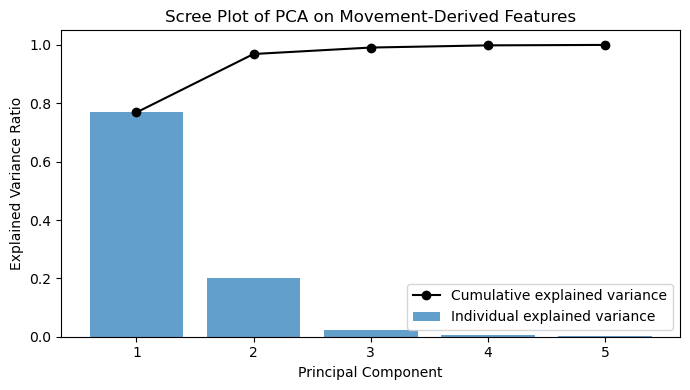

In [91]:
plt.figure(figsize=(7, 4))

plt.bar(
    range(1, len(explained_var) + 1),
    explained_var,
    alpha=0.7,
    label="Individual explained variance"
)

plt.plot(
    range(1, len(cum_explained_var) + 1),
    cum_explained_var,
    marker="o",
    color="black",
    label="Cumulative explained variance"
)

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot of PCA on Movement-Derived Features")
plt.legend()
plt.tight_layout()
plt.show()


Scree plot shows that using 2 Principle Components is enough to explain around 90% of variance